In [1]:
import sys

sys.path.append('./source/')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate, stats
import matplotlib.cm as cm
from numpy import fft
from scipy import interpolate as intp
import importlib
import healpy

from source import plots
from source import prob_dists as pd
from utils import read_param_file, update_params

In [3]:
param_file = './source/n0.params'
params = read_param_file(param_file)
p = params

exposure = 5 * 14000 / (4 * np.pi)
p = update_params(param_file, p, 'exposure', exposure)

phipp = 7.12073e-30
fwimp = phipp * 8 * np.pi / 1e-28
fwimp = 1e-2
p = update_params(param_file, p, 'fwimp', fwimp)

print(exposure, fwimp)

5570.423008216337 0.01


In [4]:
nside = p['nside']
npix = healpy.nside2npix(nside)
lon, lat = healpy.pix2ang(nside, range(npix), lonlat=True)
ang_dists = np.rad2deg(np.arccos(np.cos(np.deg2rad(lon)) * np.cos(np.deg2rad(lat))))
good_indices = (abs(lat) >= 40)

less than zero 359164
(196608,) (98, 70144)
[]


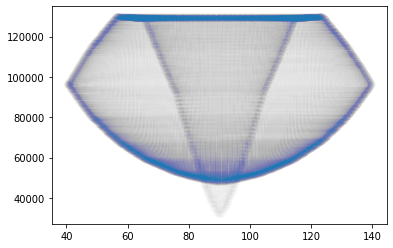

In [5]:
## S-WAVE
s_psh, s_pshfunc2d, s_fluxes, _ = pd.psh_s(ang_dists[good_indices], return_all=True)
s_psh = s_psh[::2]
s_fluxes = s_fluxes[::2]

print('less than zero', np.sum(s_psh <= 0))
s_counts = np.arange(0, 500)
print(ang_dists.shape, s_psh.shape)
print(s_psh[s_psh < 0])
plt.scatter(ang_dists[good_indices], s_psh[40], alpha=0.005)

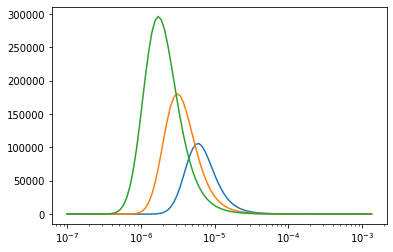

In [6]:
for i in [4000, 24000, 57000]:
    plt.plot(s_fluxes, s_psh[:, i])
plt.xscale('log')

less than zero 359164


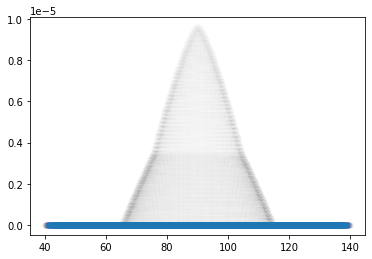

In [7]:
## SOM
som_psh, som_pshfunc2d, som_fluxes, _= pd.psh_som(ang_dists[good_indices], return_all=True)
print('less than zero', np.sum(s_psh <= 0))
som_counts = np.arange(0, 50)
plt.scatter(ang_dists[good_indices], som_psh[0], alpha=0.005)

In [8]:
# backgrounds
gal_bg = np.load(p['gal_flux_bg_file'])[good_indices] * p['exposure']
iso_bg = p['iso_flux_bg'] * p['exposure']
bg_count = gal_bg + iso_bg

In [9]:
# pc for generating skymaps
s_pc_of_psi = pd.pc_of_psi(p, s_pshfunc2d, s_fluxes, s_counts)
som_pc_of_psi = pd.pc_of_psi(p, som_pshfunc2d, som_fluxes, som_counts)

# choose between s and som
pc_of_psi = s_pc_of_psi 

background = True 



In [10]:
# search parameters
num_search = 200
p['fwimp'] *= 1

fwimps = np.logspace(np.log10(p['fwimp'])-2, np.log10(p['fwimp'])+2, num_search)
# fwimps = np.logspace(np.log10(p['fwimp'])-0.5, np.log10(p['fwimp'])+0.5, num_search)

exposure_search = np.logspace(0, 1.5, num=5) * p['exposure']

In [11]:
# run likelihoods
s_S = np.zeros((len(exposure_search), num_search))
som_S = np.zeros((len(exposure_search), num_search))
poisson_S = np.zeros((len(exposure_search), num_search))

total, mean, std, meanpc = [], [], [], []
for i, exposure in enumerate(exposure_search):
    p['exposure'] = exposure

    gal_bg = np.load(p['gal_flux_bg_file'])[good_indices] * p['exposure']
    iso_bg = p['iso_flux_bg'] * p['exposure']
    bg_count = gal_bg + iso_bg
    
    # make the simulated skymap
    psis = np.linspace(40, 180, num=50)
    pc_psi = np.array([np.trapz(1/fwimp * s_pshfunc2d(abs(psi), s_fluxes).flatten() * stats.poisson.pmf(s_counts[:, np.newaxis], p['exposure'] * fwimp * s_fluxes), fwimp * s_fluxes, axis=-1) for psi in psis])
    pc_of_psi = intp.interp1d(psis, pc_psi, axis=0)
    # generate sky map
#     pc_of_psi = pd.pc_of_psi(p, s_pshfunc2d, s_fluxes, s_counts, bg_count)
    subcounts, ang_dists, bg_counts = pd.generate_skymap_sample_pc(p, pc_of_psi, return_subcounts=True, save_output=True, with_bg=background)
    print('generated skymap with', p['fwimp'])
    print(subcounts)
#     subcounts, ang_dists, bg_counts = pd.generate_skymap_sample_pc_2(p, s_pshfunc2d, s_fluxes, return_subcounts=True, save_output=True, with_bg=background)
    if np.all(subcounts == 0):
        break
    mean_pc = np.trapz(s_counts * pc_psi[0], s_counts)
    meanpc.append(mean_pc)
    print('mean pc', mean_pc)
    total.append(subcounts.sum())
    mean.append(subcounts.mean())
    std.append(subcounts.std())
    print('total subcounts', np.sum(subcounts), '\t mean', subcounts.mean(), '\t std', subcounts.std())
    
    counts = np.arange(0, 1)
    
    S = pd.likelihood(p, s_psh, subcounts.astype(np.int16), s_fluxes, counts, fwimps, bg_count=bg_count)
    s_S[i] = S
    print('finish swave')
    
    S = pd.likelihood(p, som_psh, subcounts.astype(np.int16), som_fluxes, counts, fwimps/100, bg_count=bg_count)
    som_S[i] = S
    print('finish som')
    
    S = pd.poisson_likelihood(p, s_psh, subcounts.astype(np.int16), s_fluxes, counts, fwimps, bg_count=bg_count)
    poisson_S[i] = S
    print('finish poi')
    
    print(i+1, '/', len(exposure_search))

saved in ./output/n0_skymap_45458.npy
generated skymap with 0.01
[ 9. 10. 12. ...  7.  3.  6.]
mean pc 0.001213292529208862
total subcounts 837963.0 	 mean 11.946324703467154 	 std 5.136665711642383
finish swave
finish som
finish poi
1 / 5
saved in ./output/n0_skymap_47847.npy
generated skymap with 0.01
[18. 12. 24. ... 23. 23. 19.]
mean pc 0.002877170001041621
total subcounts 1989717.0 	 mean 28.366175296532848 	 std 10.54579875051355
finish swave
finish som
finish poi
2 / 5
saved in ./output/n0_skymap_12650.npy
generated skymap with 0.01
[54. 53. 50. ... 52. 48. 56.]
mean pc 0.0068228452871886185
total subcounts 4716981.0 	 mean 67.24710595346716 	 std 23.116409405207904
finish swave
finish som
finish poi
3 / 5
saved in ./output/n0_skymap_61868.npy
generated skymap with 0.01
[108.  98. 122. ... 118. 103. 125.]
mean pc 0.016179515911836636
total subcounts 11191244.0 	 mean 159.54670392335765 	 std 52.69981486114209
finish swave
finish som
finish poi
4 / 5
saved in ./output/n0_skymap_6

Text(0.5, 1.0, 'total counts')

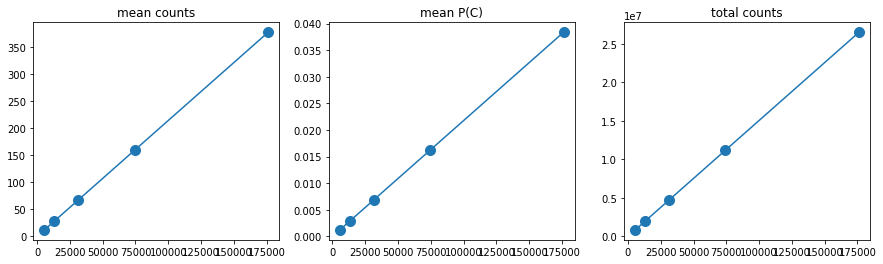

In [12]:
fig, axs = plt.subplots(ncols=3, figsize=(15,4))
axs[0].plot(exposure_search, mean, label='mean', marker='o', ms=10)
axs[0].set_title('mean counts')
axs[1].plot(exposure_search, meanpc, label='P(C) mean', marker='o', ms=10)
axs[1].set_title('mean P(C)')
axs[2].plot(exposure_search, total, label='P(C) mean', marker='o', ms=10)
axs[2].set_title('total counts')

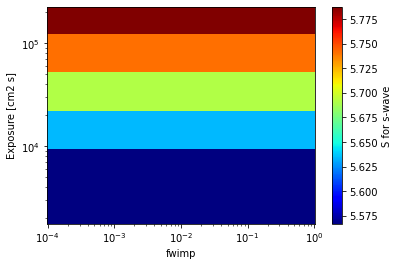

In [13]:
fig, ax = plt.subplots(figsize=(6, 4))
# ax.set_ylim(bottom=0, top=)
ax.set_yscale('log')
ax.set_ylabel('Exposure [cm2 s]')
ax.set_xscale('log')
ax.set_xlabel('fwimp')
pc = ax.pcolormesh(fwimps, exposure_search, np.log10(s_S), cmap=cm.jet, shading='auto')
fig.colorbar(pc, label='S for s-wave');

In [14]:
np.amax(s_S, axis=-1), s_S[:, -1]


(array([368595.88844256, 430857.09216187, 491448.8316485 , 551905.37683339,
        613514.1189796 ]),
 array([368595.88844256, 430857.09216187, 491448.8316485 , 551905.37683339,
        613514.1189796 ]))

s-wave L 368564.8772894202 	 0.0001
s-wave L 430807.18908871355 	 0.06517339604882427
s-wave L 491286.82540164515 	 0.0001
s-wave L 551544.6328111353 	 0.02833096101839324
s-wave L 612720.4271933127 	 0.0001
som L 368730.8704218799 	 1e-06
som L 430973.2141288798 	 0.0009437878277775381
som L 491452.8183109339 	 1e-06
som L 551710.6190883166 	 0.00047137531341167243
som L 612886.4197329473 	 1e-06
poisson L 368730.8706197826 	 0.0001
poisson L 430973.196315867 	 0.05941133984965034
poisson L 491452.81873213605 	 0.0001
poisson L 551710.6218470293 	 0.02833096101839324
poisson L 612886.4205237854 	 0.0001
0.01


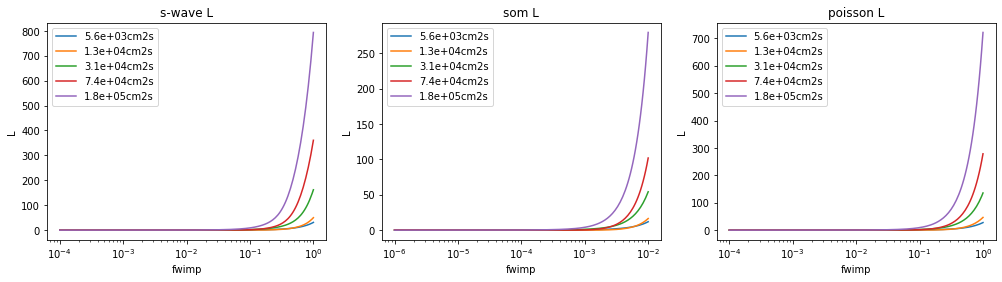

In [15]:
fig, axs = plt.subplots(ncols=3, figsize=(17, 4))
i = 0
lw = 5
zorder = 1

for ax, s, lab in zip(axs, [s_S, som_S, poisson_S], ['s-wave L', 'som L', 'poisson L']):
    colors = iter(['xkcd:mulberry', 'xkcd:wheat', 'xkcd:mossy green', 'xkcd:cool blue', 'xkcd:blush pink'])
    for expdat, expo in zip(s, exposure_search):
        if lab == 'som L':
#             ax.plot(fwimps / 100, np.exp(-0.5*(expdat - expdat.min())), label=f'{expo:.2}cm2s', alpha=0.9, lw=1, color=next(colors))
            ax.plot(fwimps/100, expdat - expdat.min(), label=f'{expo:.2}cm2s')
            print(lab, expdat.min(),  '\t', fwimps[np.exp(-0.5*(expdat - expdat.min())).argmax()]/100)
        else:
#             ax.plot(fwimps, np.exp(-0.5*(expdat - expdat.min())), label=f'{expo:.2}cm2s', alpha=0.9, lw=1, color=next(colors))
            ax.plot(fwimps, expdat - expdat.min(), label=f'{expo:.2}cm2s')
            print(lab, expdat.min(),  '\t', fwimps[np.exp(-0.5*(expdat - expdat.min())).argmax()])

        

    ax.set_xscale('log')
    ax.set_xlabel('fwimp')
    ax.set_ylabel('L')
    
    ax.set_title(lab)
    ax.legend()
#     ax.set_yscale('log')
#     ax.set_ylim(bottom=0, top=10)
print(p['fwimp'])

In [16]:
max_swave = np.amin(s_S, axis=-1)
max_som = np.amin(som_S, axis=-1)
max_poi = np.amin(poisson_S, axis=-1)

In [17]:
max_swave - max_som, max_swave - max_poi, max_som - max_poi

(array([-165.99313246, -166.02504017, -165.99290929, -165.98627718,
        -165.99253963]),
 array([-165.99333036, -166.00722715, -165.99333049, -165.98903589,
        -165.99333047]),
 array([-0.0001979 ,  0.01781301, -0.0004212 , -0.00275871, -0.00079084]))

Text(0, 0.5, '$-2\\Delta\\ln\\mathcal{L}$')

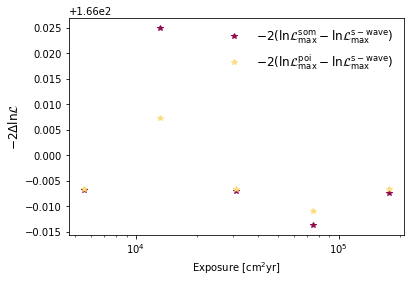

In [18]:
fig, ax = plt.subplots()
colors = iter(['xkcd:mulberry', 'xkcd:wheat', 'xkcd:mossy green', 'xkcd:cool blue', 'xkcd:blush pink'])
ax.plot(exposure_search, max_som - max_swave, marker='*', ls='', color=next(colors), label=r'$-2(\ln\mathcal{L}_\mathrm{max}^\mathrm{som} - \ln\mathcal{L}_\mathrm{max}^\mathrm{s-wave})$')
ax.plot(exposure_search, max_poi - max_swave, marker='*', ls='', color=next(colors), label=r'$-2(\ln\mathcal{L}_\mathrm{max}^\mathrm{poi} - \ln\mathcal{L}_\mathrm{max}^\mathrm{s-wave})$')
ax.legend(fontsize='large', frameon=False)
ax.set_xscale('log')
# ax.set_yscale('log')

ax.set_xlabel(r'Exposure [$\mathrm{cm}^2\mathrm{yr}$]')
ax.set_ylabel(r'$-2\Delta\ln\mathcal{L}$', fontsize='large')
